In [1]:
import tensorflow as tf
# print(tf.__version__)
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print("Yes" if tf.config.list_physical_devices("GPU") else "No")

Yes


In [3]:
labels_csv = pd.read_csv(r"dog-breed-identification\labels.csv")


In [4]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

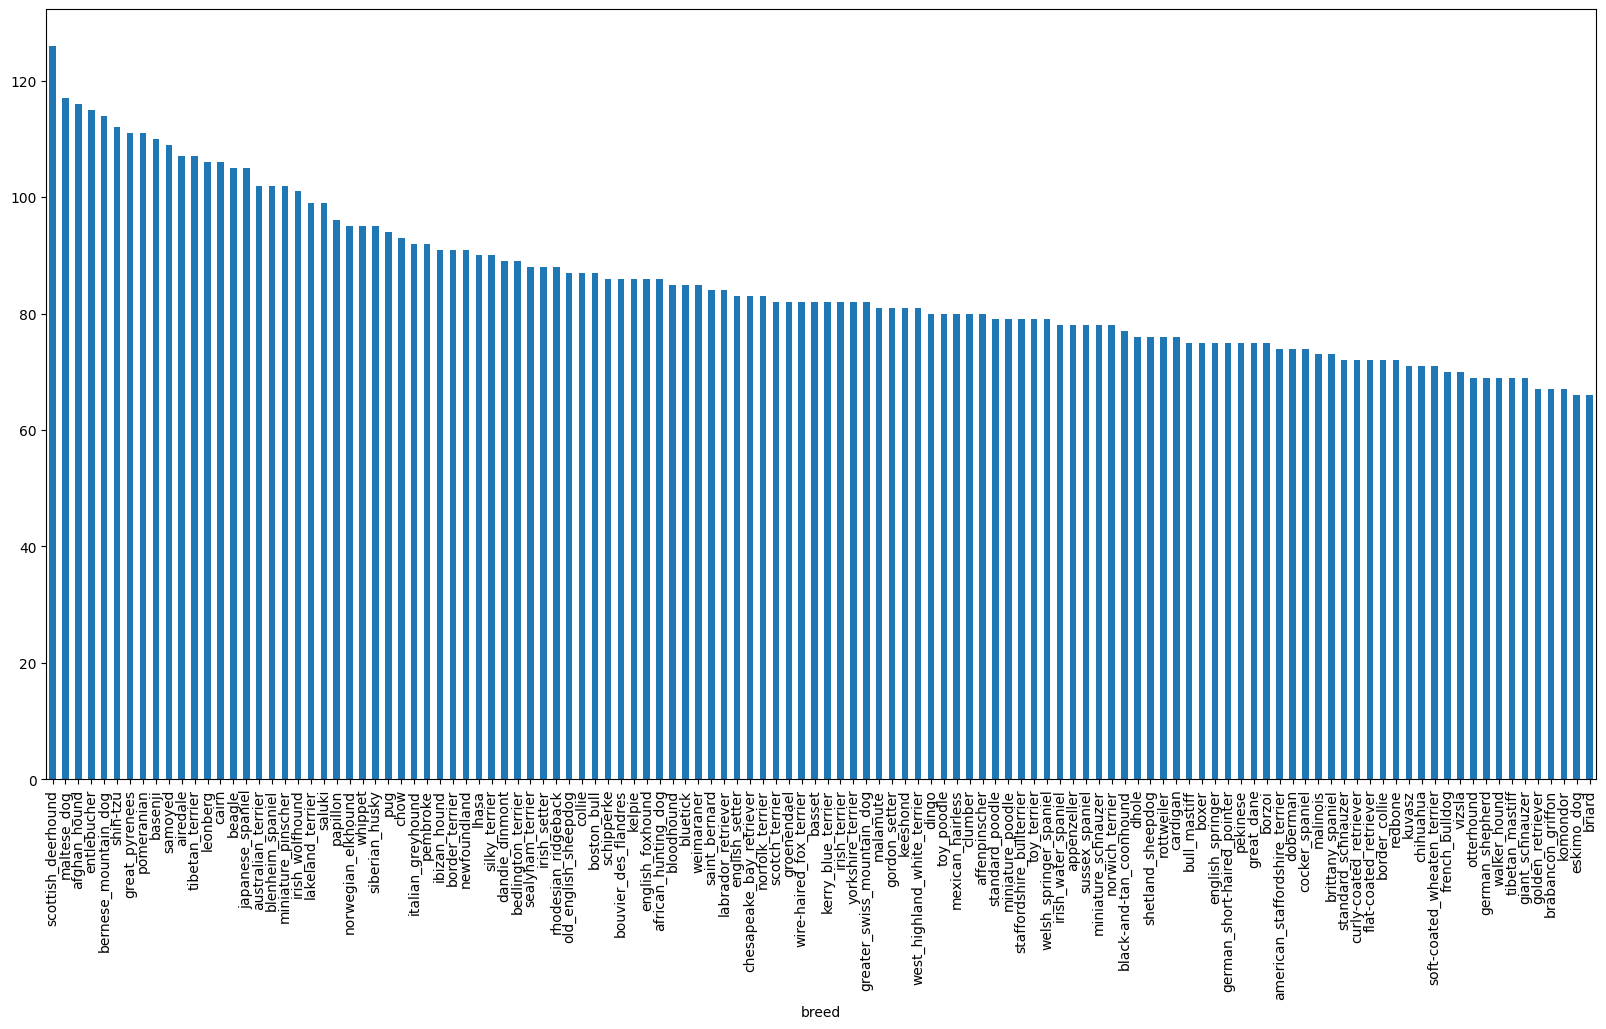

In [5]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [6]:
filenames = [r"dog-breed-identification/train/" + name + ".jpg" for name in labels_csv['id']]
filenames[:5]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

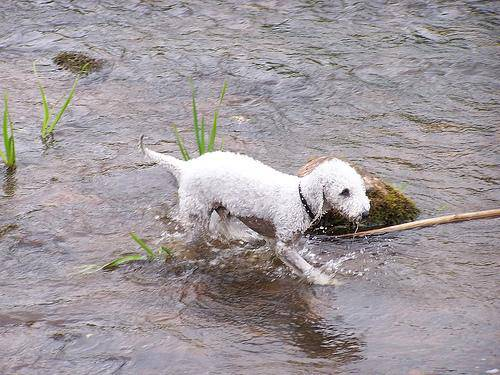

In [7]:
from IPython.display import display,Image
Image(filenames[5])

In [8]:
len(filenames)

10222

In [9]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [10]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [11]:
# unique_breeds

In [12]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [13]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [14]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

In [15]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [16]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

In [17]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape

(257, 350, 3)

In [18]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [19]:
# Define image size

IMG_SIZE = 224

def process_image(image_path, augment=False):
    """
    Takes an image file path and turns it into a Tensor.
    Optionally applies data augmentation.
    """
    # Read in the image file
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the image to float32 and normalize it to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to the desired size
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    if augment:
        # Apply random transformations
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_jpeg_quality(image, min_jpeg_quality=75, max_jpeg_quality=100)
    
    return image


In [20]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label
     


In [21]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

def create_data_batches(x, y=None, batch_size=BATCH_SIZE, augment=False, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (x) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
    Also accepts test data as input (no labels).
    """
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(lambda x: process_image(x, augment=False)).batch(batch_size)
        return data_batch

    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(lambda x, y: (process_image(x, augment=False), y)).batch(batch_size)
        return data_batch

    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data = data.map(lambda x, y: (process_image(x, augment=augment), y))
        data_batch = data.batch(batch_size)
        return data_batch


In [22]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train, augment=True)
val_data = create_data_batches(X_val, y_val, valid_data=True)


Creating training data batches...
Creating validation data batches...


In [23]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [24]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(15, 15))
  
  for i in range(25):
    
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

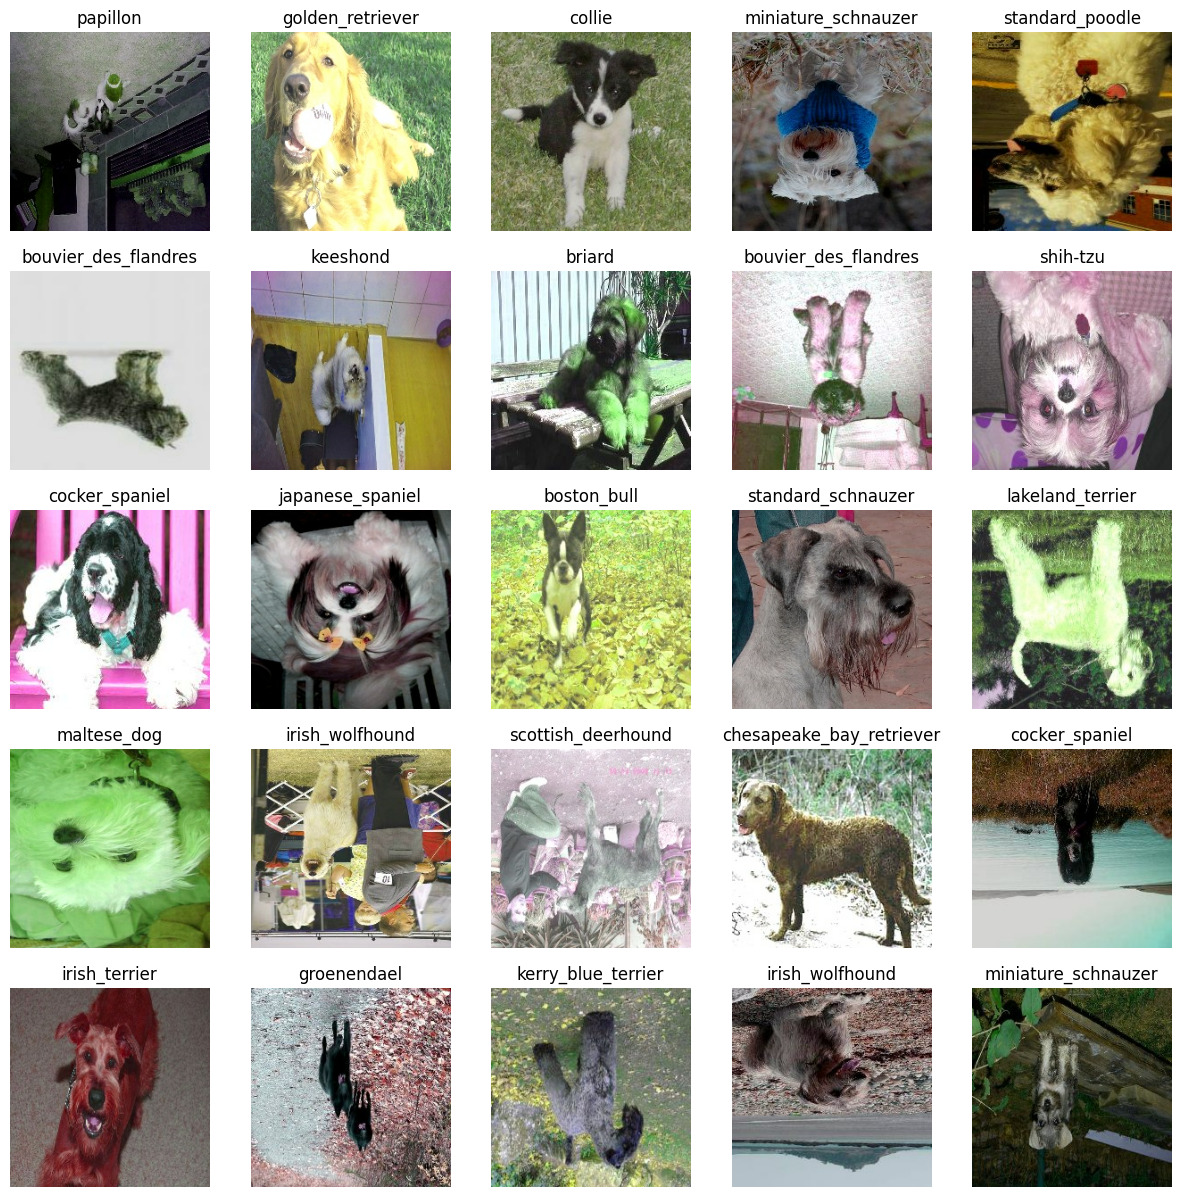

In [25]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [26]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels
# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) 

MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2"

In [27]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), 
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model


In [28]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [29]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [30]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Dog vision project/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [31]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

In [32]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [33]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()
  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

  return model

In [34]:
import os

In [35]:
# Fit the model to the data
model = train_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Epoch 1/100
25/25 [==============================] - 14s 193ms/step - loss: 5.4197 - accuracy: 0.0350 - val_loss: 4.2536 - val_accuracy: 0.1100
Epoch 2/100
25/25 [==============================] - 4s 167ms/step - loss: 3.4262 - accuracy: 0.2212 - val_loss: 3.2460 - val_accuracy: 0.2550
Epoch 3/100
25/25 [==============================] - 4s 169ms/step - loss: 2.3115 - accuracy: 0.4613 - val_loss: 2.6418 - val_accuracy: 0.3600
Epoch 4/100
25/25 [==============================] - 5s 181ms/step - loss: 1.6810 - accuracy: 0.5900 - val_loss: 2.3164 - val_accuracy: 0.4100
Epoch 5/100
25/25 [==============================] - 5s 179ms/step - loss: 1.2981 - accuracy: 0.6787 - val_loss: 2.0916 - val_accuracy: 0.4550
Epoch 6/100
25/25 [==============================] - 5s 180ms/step - loss: 1.0130 - accuracy: 0.7625 - val_loss: 1.9223 - val_accuracy: 0.5150
Epoch 7/100
25/25 [==============

In [36]:
%tensorboard --logdir /content/drive/MyDrive/Dog\ vision\ project/logs

Reusing TensorBoard on port 6006 (pid 8428), started 4 days, 5:55:15 ago. (Use '!kill 8428' to kill it.)

In [37]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 1s 61ms/step


array([[2.9666536e-04, 1.6840930e-05, 5.7846471e-04, ..., 6.0788036e-04,
        3.2629268e-04, 7.8739012e-03],
       [4.1835886e-04, 1.2580532e-03, 1.1781497e-02, ..., 8.5611438e-04,
        1.1342712e-02, 1.2346225e-04],
       [1.8901864e-06, 9.3055678e-05, 2.9720179e-05, ..., 6.8978290e-05,
        3.6407535e-05, 9.6879952e-04],
       ...,
       [4.5489264e-06, 6.0731298e-05, 2.1040373e-04, ..., 1.1441662e-05,
        4.3850836e-05, 1.8447038e-04],
       [4.3231589e-04, 1.2108472e-04, 1.3253147e-05, ..., 1.1012353e-04,
        7.7718621e-05, 1.2108457e-03],
       [2.5554316e-05, 4.1939039e-04, 5.7361880e-04, ..., 3.2094931e-03,
        1.6873572e-03, 5.9154106e-04]], dtype=float32)

In [38]:
# Check the shape of predictions
predictions.shape

(200, 120)

In [39]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label
     

[2.96665356e-04 1.68409297e-05 5.78464707e-04 4.39925461e-05
 6.11189680e-05 5.23648714e-06 8.18600040e-03 2.39386747e-04
 1.92320458e-05 3.01635329e-04 1.61451044e-05 8.20533569e-06
 1.34790796e-04 1.42268982e-04 9.57005177e-05 2.79266911e-04
 5.44092436e-05 2.45195866e-01 3.36510711e-04 6.98045769e-05
 1.51854486e-03 4.71072162e-05 3.57877252e-05 1.04585001e-02
 8.54428799e-05 6.94402552e-05 4.10362147e-02 4.14776005e-05
 3.13797384e-04 1.79641967e-04 2.05988443e-04 9.39523918e-04
 1.12106594e-04 1.99319784e-05 3.47474052e-05 1.13649918e-02
 1.44184041e-05 1.69100857e-03 6.98055082e-05 3.95559800e-05
 3.16394726e-03 4.49318068e-05 1.59735755e-05 6.15213066e-05
 5.68251016e-06 4.52071050e-04 5.14492713e-05 2.00756404e-04
 8.00757378e-04 7.88579273e-05 3.43894899e-05 3.01112043e-04
 1.42689183e-04 2.12948680e-06 1.25201186e-05 1.69744715e-04
 8.55169783e-05 1.62413542e-03 4.75101144e-04 9.98595059e-02
 4.04112361e-05 1.29946002e-05 2.41624890e-04 5.90963391e-05
 8.07845936e-05 6.382343

In [40]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'soft-coated_wheaten_terrier'

In [41]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [42]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

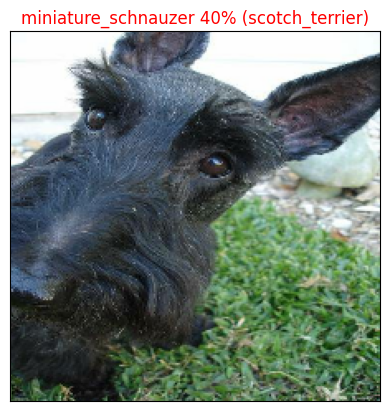

In [43]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [44]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

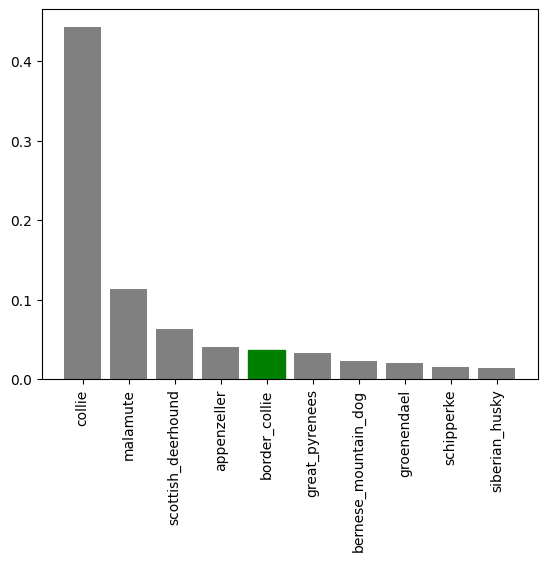

In [45]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

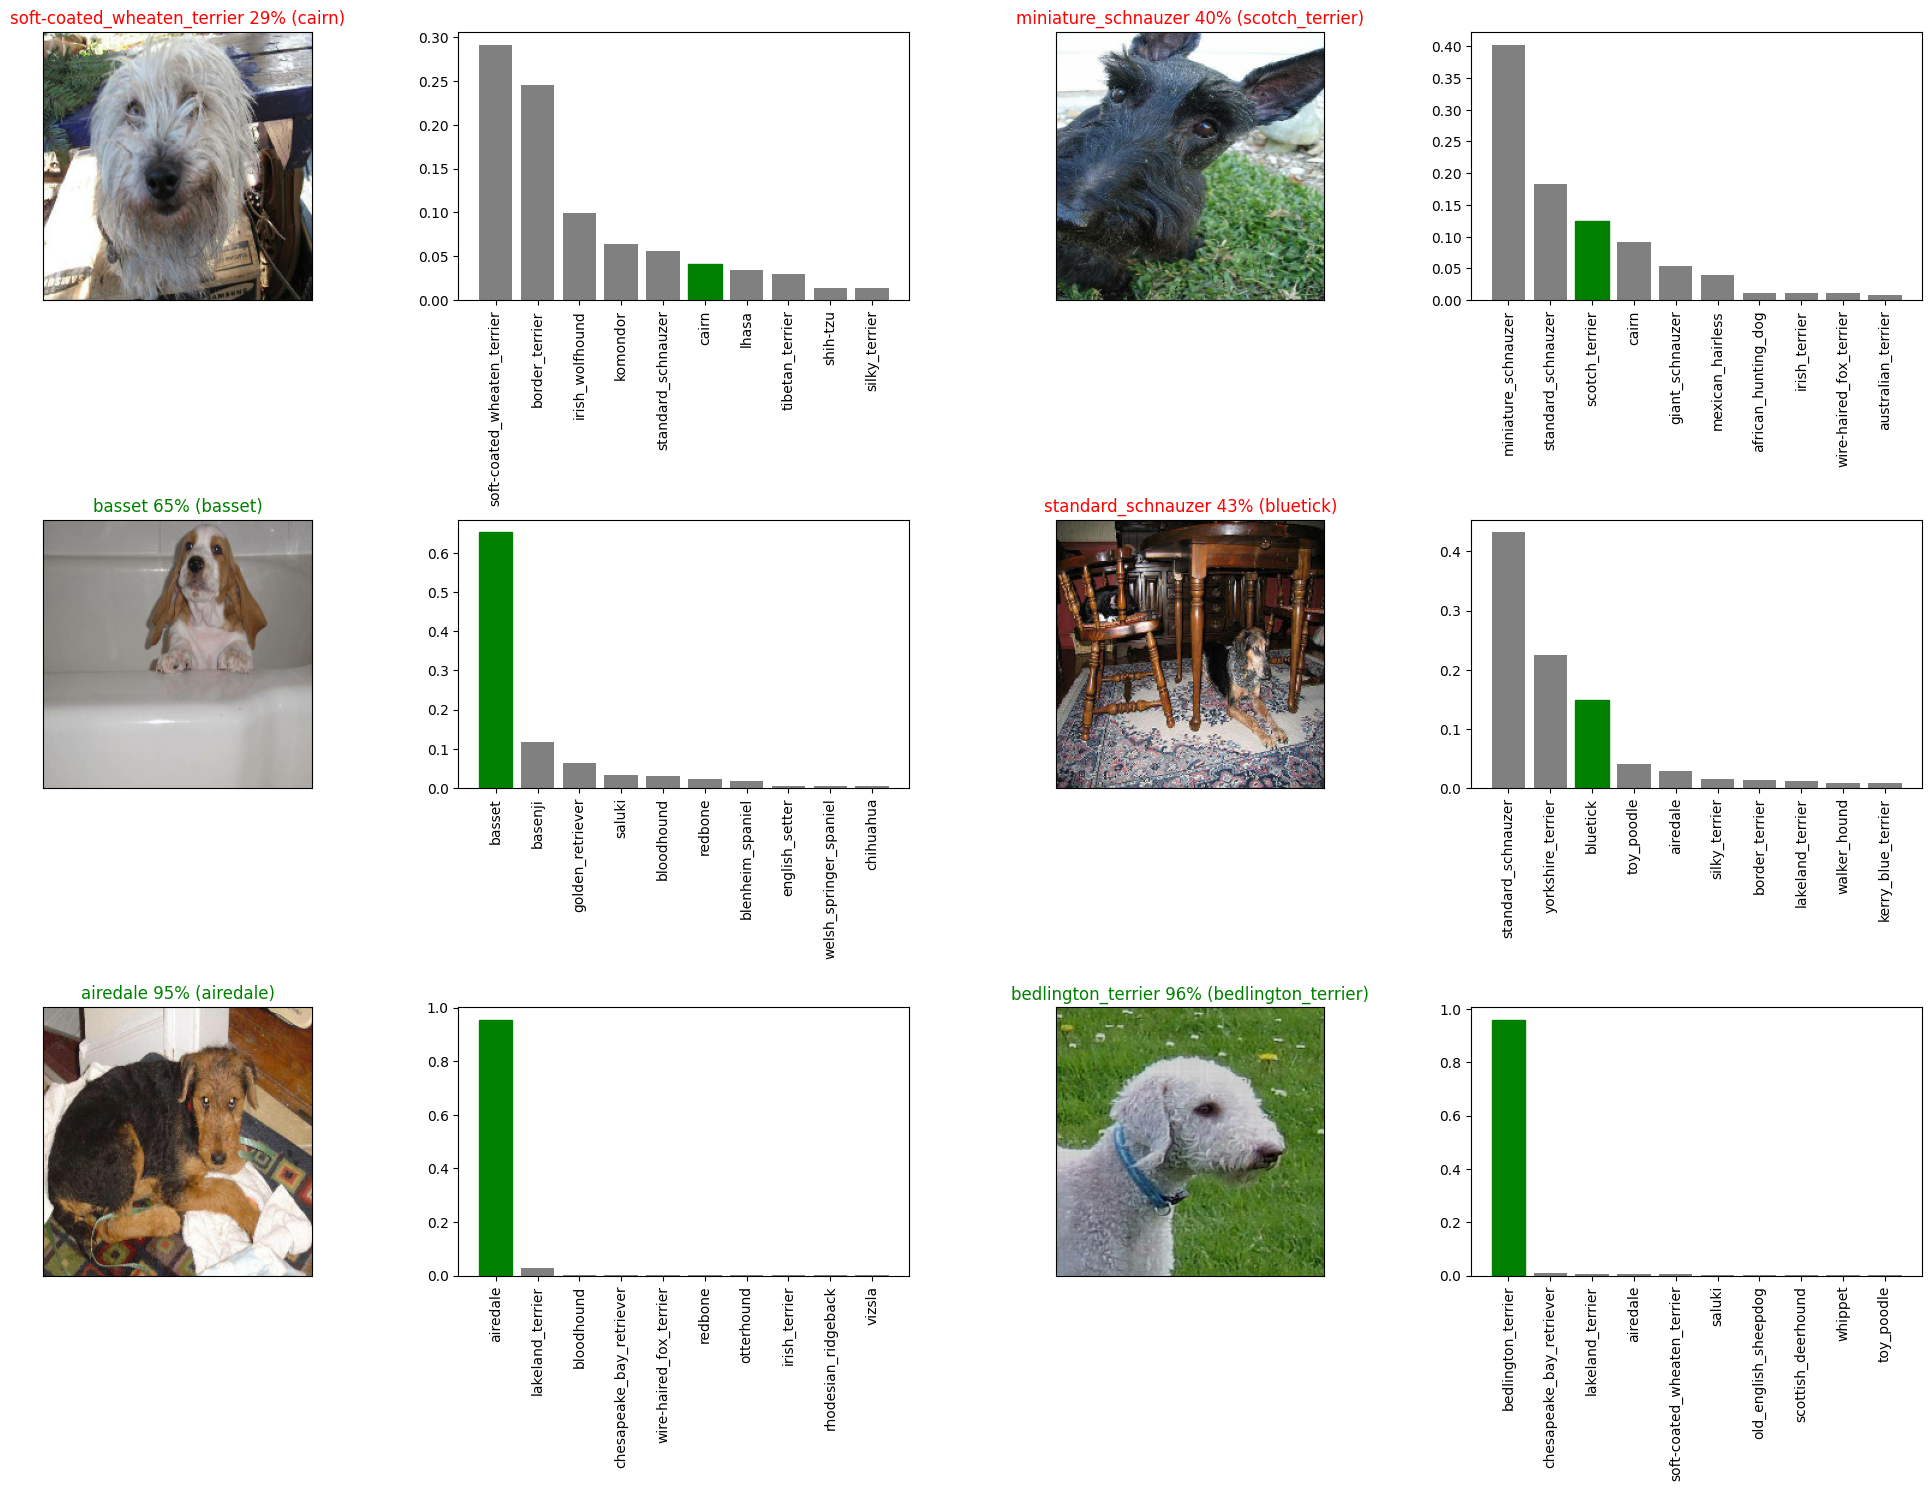

In [46]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()
     

In [47]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [48]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [49]:
# Save our model trained on 1000 images
save_model(model, suffix="1000_images-Adam")

Saving model to: models\2024-05-18_19-26-37-1000_images-Adam.h5...


'models\\2024-05-18_19-26-37-1000_images-Adam.h5'

In [50]:
# Load our model trained on 1000 images
model_1000_images = load_model(r"models\2024-05-16_09-56-58-1000_images-Adam.h5")

Loading saved model from: models\2024-05-16_09-56-58-1000_images-Adam.h5


In [51]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 61ms/step - loss: 1.6077 - accuracy: 0.5950


[1.6076854467391968, 0.5950000286102295]

In [52]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 1s 59ms/step - loss: 1.2656 - accuracy: 0.6600


[1.265586018562317, 0.6600000262260437]

In [53]:
# Remind ourselves of the size of the full dataset
len(X), len(y)

(10222, 10222)

In [54]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


In [55]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2


In [56]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=1)

In [57]:
%tensorboard --logdir /content/drive/MyDrive/Dog vision project/logs


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

In [58]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 28s 70ms/step - loss: 1.3336 - accuracy: 0.6718
Epoch 2/100
320/320 [==============================] - 22s 69ms/step - loss: 0.3981 - accuracy: 0.8833
Epoch 3/100
320/320 [==============================] - 22s 70ms/step - loss: 0.2350 - accuracy: 0.9388
Epoch 4/100
320/320 [==============================] - 22s 70ms/step - loss: 0.1518 - accuracy: 0.9658
Epoch 5/100
320/320 [==============================] - 23s 71ms/step - loss: 0.1065 - accuracy: 0.9787
Epoch 6/100
320/320 [==============================] - 23s 71ms/step - loss: 0.0778 - accuracy: 0.9863
Epoch 7/100
320/320 [==============================] - 23s 71ms/step - loss: 0.0588 - accuracy: 0.9919
Epoch 8/100
320/320 [==============================] - 23s 71ms/step - loss: 0.0456 - accuracy: 0.9951
Epoch 9/100
320/320 [==============================] - 24s 75ms/step - loss: 0.0365 - accuracy: 0.9964
Epoch 10/100
320/320 [==============================] - 28s 87ms/step - l

In [59]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

Saving model to: models\2024-05-18_19-32-23-all-images-Adam.h5...


'models\\2024-05-18_19-32-23-all-images-Adam.h5'

In [60]:
# Load in the full model
loaded_full_model = load_model(r'models\2024-05-14_16-41-38-all-images-Adam.h5')
     

Loading saved model from: models\2024-05-14_16-41-38-all-images-Adam.h5


In [61]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg',
 'dog-breed-identification/test/00102ee9d8eb90812350685311fe5890.jpg',
 'dog-breed-identification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'dog-breed-identification/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'dog-breed-identification/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'dog-breed-identification/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'dog-breed-identification/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'dog-breed-identification/test/002f80396f1e3db687c5932d7978b196.jpg',
 'dog-breed-identification/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [62]:
# How many test images are there?
len(test_filenames)

10357

In [63]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)
     

Creating test data batches...


In [64]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 24s 69ms/step


In [65]:
# Check out the test predictions
test_predictions[:10]

array([[6.1306134e-12, 4.3511191e-13, 9.5407953e-15, ..., 1.5008089e-14,
        5.1673332e-11, 1.5422328e-11],
       [1.5130365e-06, 6.3615921e-08, 9.0038315e-09, ..., 3.3136605e-11,
        3.0422888e-07, 6.7353145e-10],
       [3.0166123e-11, 2.0400651e-06, 1.4648879e-09, ..., 7.8501763e-08,
        8.7943949e-12, 1.5821264e-11],
       ...,
       [1.8913608e-09, 5.9436887e-12, 4.3232078e-11, ..., 1.0769358e-12,
        2.4682075e-12, 1.1608673e-10],
       [1.9191350e-11, 1.2526710e-09, 8.7656889e-11, ..., 7.6403666e-07,
        1.7298749e-09, 2.1636018e-11],
       [1.2676570e-09, 3.8788670e-11, 2.4103838e-10, ..., 2.0761940e-13,
        6.4617735e-11, 5.3244811e-08]], dtype=float32)

Custom Predictions

In [66]:
# Get custom image filepaths
custom_path = "custom_dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [67]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [68]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 0s 223ms/step


In [69]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['afghan_hound',
 'airedale',
 'bernese_mountain_dog',
 'great_dane',
 'golden_retriever',
 'golden_retriever',
 'samoyed',
 'malinois',
 'welsh_springer_spaniel',
 'shih-tzu']

In [70]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

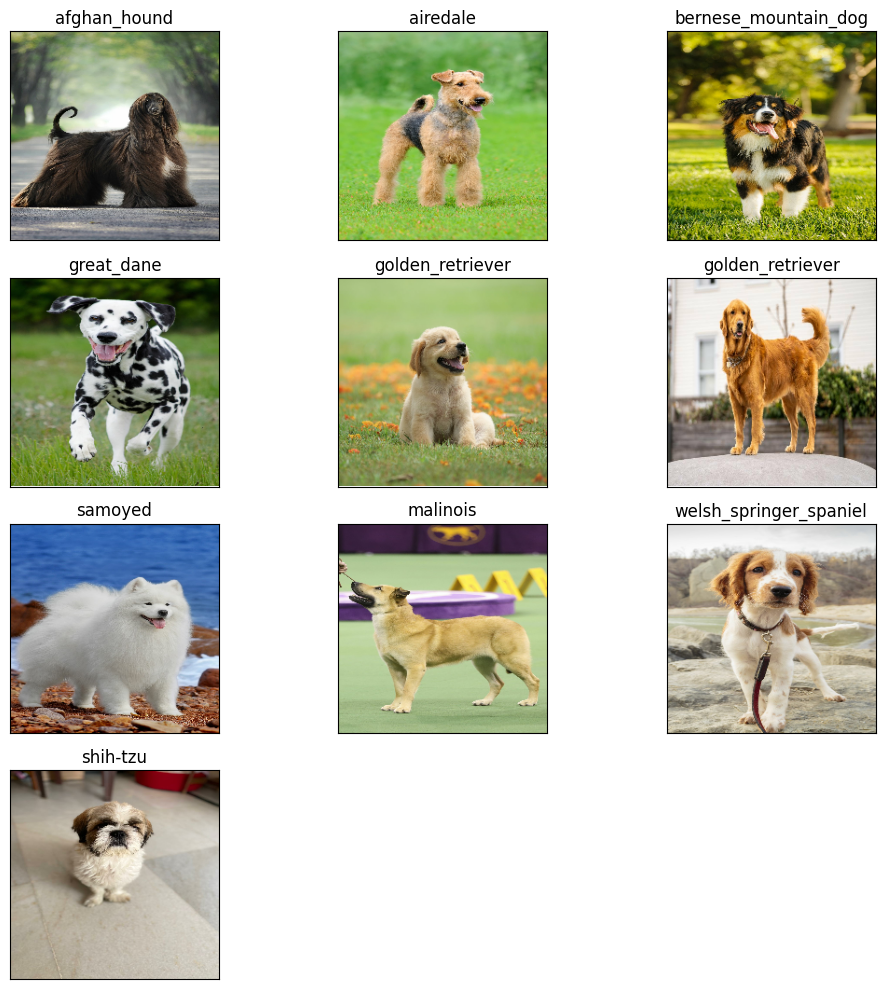

In [71]:
import math

num_images = len(custom_images)
rows = math.ceil(num_images / 3)  # Calculate the number of rows needed

plt.figure(figsize=(10, 10))

for i, image in enumerate(custom_images):
    plt.subplot(rows, 3, i + 1)  # Adjust the subplot parameters
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()